<a href="https://colab.research.google.com/github/zomorodiyan/MAE-5093/blob/main/MAE5093_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework 2** of the course **MAE-5093** Fall 2021, questions **2, 3, 4, 6, 8** from **Fundamentals of Engineering Numerical Analysis** Second Edition

<h2>by Mehrdad Zomorodiyan<h2>

link to the questions: https://drive.google.com/file/d/1mAihH4eMKmAP0l-MJe6PEcs0h91mNRYa/view?usp=sharing 

In [384]:
#@title Setup
#!pip install sympy
from sympy import symbols, diff, poly, Function, factorial, Matrix, zeros
import numpy as np
x, h, a, b = symbols('x, h, a, b')
a1, a2, a3, a4, a5, a6 = symbols('a1, a2, a3, a4, a5, a6')                      
f = Function('f')

In [385]:
#@title define tay
#define tay(j,k) that returns taylor_expansion, j:distance from x, k:number of terms from taylor serie
def tay(j,k): return sum((h*j)**i/factorial(i)*f(x).diff(x, i) for i in range(abs(k)))

In [386]:
#@title two tests for tay
import unittest
class TestTaylor(unittest.TestCase):
    def test_2terms(self):
        '''Test case function for first 2 terms of taylor series for f(x+1)'''
        result = tay(1,2)
        expected = f(x) + h*f(x).diff(x,1)
        self.assertEqual(result, expected)
    def test_3terms(self):
        '''Test case function for first 3 terms of taylor series for f(x-2)'''
        result = tay(-2,3)
        expected = f(x) - 2*h*f(x).diff(x,1) + 2*h**2*f(x).diff(x,2)
        self.assertEqual(result, expected)


In [387]:
#@title define equation (helper method for disceritize)
def equation(vars,order,coeffs,coeffs2,orders\
        ,x=symbols('x'),h=symbols('h'),f=Function('f')):
    return sum( vars[i]*tay(coeffs[i],order).diff(x,orders[i])*coeffs2[i]\
            for i in range(len(vars)) )

In [388]:
#@title define discretize
# gets a set of coeficient(vars),number of terms for taylor expansions(order),
#   distance from the refrence point for each term (coeffs) also known
#   coeficients for each(coeffs2), order of derivetive for each term(orders)
# returns the solution for the unknowns in vars
def discretize(vars,nvars,coeffs,coeffs2,orders\
        ,x=symbols('x'),h=symbols('h'),f=Function('f')):
    mat1 = zeros(nvars,nvars)
    mat2 = zeros(nvars,1)
    order=nvars-1 #start here, will go higher if some equations are always-true
    eq_count = 0
    while(eq_count < nvars):
        eq_count = 0
        eq = equation(vars,order,coeffs,coeffs2,orders)
        for i in range(order):
            p = poly(eq,[f(x).diff(x,i)]); c = p.coeffs()[0]
            mat2[i,0] = -c
            nonzero=False
            for j in range(nvars):
                C = poly(c,[vars[j]]).coeffs()
                if len(C)==2:
                    mat1[eq_count,j] = C[0]
                    mat2[eq_count,0] += C[0]*vars[j]
                    nonzero=True
            if nonzero:
                eq_count += 1
        if eq_count < nvars:
            #print('order',order,'is not enough; go higher')
            order += 1
    return (mat1.inv()*mat2)[:,0]

In [389]:
#@title test for discretize: $\frac{du}{dx}|_j= \frac{1}{2h}(a_1 u_{j}+a_2 u_{j+1}+a_3 u_{j+2})+O(h^n)$ $∴[a_1,a_2,a_3]=[-3,4,-1]$
class TestDiscretize(unittest.TestCase):
    def test_eq21(self):
        vars = Matrix([a1,a2,a3,1]); nvars = len(vars)-1 #n of unknowns
        coeffs=[0,1,2,0]
        coeffs2=[1/2/h,1/2/h,1/2/h,-1]
        orders=[0,0,0,1]
        result = discretize(vars,nvars,coeffs,coeffs2,orders)
        expected = Matrix([[-3],[4],[-1]])
        self.assertEqual(result, expected)


In [390]:
#@title run tests
unittest.main(argv=[''], verbosity=1, exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.320s

OK


### **Question 2**

In [391]:
#@title define variables of $\frac{du}{dx}|_j= \frac{1}{h}(a_1 u_{j-1}+a_2 u_{j}+a_3 u_{j+1}+a_4 u_{j+2})+O(h^n)$
vars = Matrix([a1,a2,a3,a4,1]); nvars = len(vars)-1 #n of unknowns
coeffs=[-1,0,1,2,0]
coeffs2=[1/h,1/h,1/h,1/h,-1]
orders=[0,0,0,0,1]

In [392]:
#@title calculate $result =[a_1,a_2,a_3,a_4]$ , form the equation, show  $lhs - rhs$
result = discretize(vars,nvars,coeffs,coeffs2,orders)
num = 6
eq = f(x).diff(x,1) - equation(result,num,coeffs,coeffs2,orders) 
for i in range(num):
  p = poly(eq,[f(x).diff(x,i)]); c = p.coeffs()
  print(0 if len(c)==1 else c[0],"f"+"'"*i, end=' + ')


0 f + 0 f' + 0 f'' + 0 f''' + h**3/12 f'''' + h**4/30 f''''' + 

the leading error term is $\frac{h^3}{12}f''''_{xi}$ so the **order is $3$**

### **Question 3**

the fourth-order pade scheme: $f'_{i-1}+f'_{i}+4f'_{i+1} = \frac{3}{h}(f_{i+1}-f_{i-1})$

$f_i = e^{ikx_i}⇒ik'(e^{ik(x_i-h)}+4e^{ikx_i}+e^{ik(x_i+h)}) = \frac{3}{h}(e^{ik(x_i+h)}-e^{ik(x_i-h)})$

$⇒ik'(e^{-ikh}+4+e^{ikh}) = \frac{3}{h}(e^{ikh}-e^{-ikh})$

$⇒ ik'(4+2cos(kh))=\frac{3}{h}(2i sin(kh))$

$⇒ k'=\frac{3sin(kh)}{h(2+cos(kh))}$

### **Question 4**

In [393]:
#@title define variables according to the equation 
vars = Matrix([a1,a2,a3,a4,1,1]); nvars = len(vars)-2 #n of unknowns
coeffs=[0,1,2,3,0,1]
coeffs2=[1/h,1/h,1/h,1/h,-1,-a]
orders=[0,0,0,0,1,1]

<h3>4-a<h3>

In [394]:
#@title calculate $result =[a,b,c,d]$ , form the equation, show  $lhs - rhs$
result = discretize(vars,nvars,coeffs,coeffs2,orders)
print('[a,b,c,d]=',result)
num = 6
eq = f(x).diff(x,1) + a*tay(1,num).diff(x,1) - equation(result,num,coeffs,coeffs2,orders) 
for i in range(num):
  p = poly(eq,[f(x).diff(x,i)]); c = p.coeffs()
  print(0 if len(c)==1 else c[0],"f"+"'"*i, end=' + ')


[a,b,c,d]= Matrix([[-a/3 - 11/6], [3 - a/2], [a - 3/2], [1/3 - a/6]])
0 f + 0 f' + 0 f'' + 0 f''' + a*h**3/12 - h**3/4 f'''' + 7*a*h**4/60 - 3*h**4/10 f''''' + 

$\alpha=9$ would makes leading error term, $\frac{\alpha-9}{12}f''''_{xi}$ zero consequently the order of accuracy will be four

<h3>4-b<h3>

In [395]:
#@title substitude $\alpha$ with 9 as we concluded in 4-a
resultsub = result.subs(a,9)
print('[a,b,c,d]=',resultsub)

[a,b,c,d]= Matrix([[-29/6], [-3/2], [15/2], [-7/6]])


### **Question 6**

<h3> 6-a <h3>

central difference scheme: $f''_{j} = \frac{f_{j+1}-2f_{j} +f_{j-1}}{h^2}$

$f_i = e^{ikx_i}⇒ -k'^2f_j = \frac{f_{j}(e^{ikh}-2 +e^{-ikh})}{h^2}$

$⇒ k'^2h^2 = -2(cos(kh)-1)$





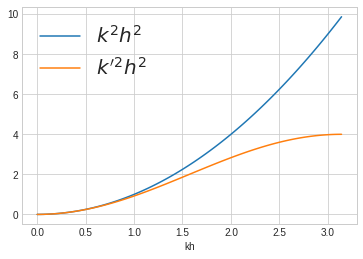

In [396]:
#@title plot
import matplotlib.pyplot as plt
kh = np.linspace(0,3.1415,100)
kh2 = kh**2
kph2 = -2*(-1+np.cos(kh))
plt.plot(kh,kh2)
plt.plot(kh,kph2)
plt.style.use('seaborn-whitegrid')
plt.xlabel("kh")
plt.legend(["$k^2h^2$","$k'^2h^2$"], prop={"size":20})

<h3> 6-b <h3>

In [397]:
#@title define variables according to the equation 
vars = Matrix([1,-2,1,1,1,1]); nvars = len(vars)-2 #n of unknowns
coeffs=[-1,0,1,-1,0,1]
coeffs2=[1/h**2,1/h**2,1/h**2,-1/12,-10/12,-1/12]
orders=[0,0,0,2,2,2]

In [398]:
#@title form the equation, show  $lhs - rhs$
num = 7
eq = equation(vars,num,coeffs,coeffs2,orders) 
for i in range(num):
  p = poly(eq,[f(x).diff(x,i)]); c = p.coeffs()
  print(0 if len(c)==1 else c[0],"f"+"'"*i, end=' + ')


0 f + 0 f' + 0 f'' + 0 f''' + 0 f'''' + 0 f''''' + -0.00416666666666667*h**4 f'''''' + 

the leading error term is $\frac{25h^{4}}{6000}f''''_{xi}$ so the **order is $4$**

<h3> 6-c <h3>

the fourth-order pade scheme: $\frac{1}{12}f''_{i-1}+\frac{10}{12}f''_{i}+\frac{1}{12}f'_{i+1} = \frac{f_{i+1}-2f_i+f_{i-1}}{h^2}$

$f_i = e^{ikx_i}⇒-k'^2(\frac{1}{12}e^{-ikh}+\frac{10}{12}+\frac{1}{12}e^{ikh})f_i = (\frac{e^{ikh}-2+e^{-ikh}}{h^2})f_i$

$⇒ -k'^2(\frac{2}{12}cos(kh)+\frac{10}{12}) = \frac{2cos(kh)-2}{h^2}$

$⇒ k'^2h^2 = \frac{1-cos(kh)}{\frac{1}{12}cos(kh)+\frac{5}{12}}$

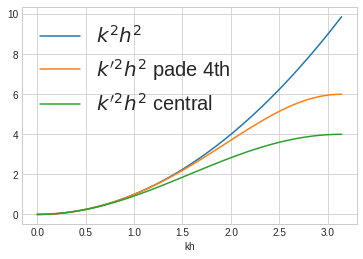

In [399]:
#@title plot
import matplotlib.pyplot as plt
kh = np.linspace(0,3.1415,100)
kh2 = kh**2
kph2pade = (1-np.cos(kh))/(1/12*np.cos(kh)+5/12)
kph2central = -2*(-1+np.cos(kh))
plt.plot(kh,kh2)
plt.plot(kh,kph2pade)
plt.plot(kh,kph2central)
plt.style.use('seaborn-whitegrid')
plt.xlabel("kh")
plt.legend(["$k^2h^2$","$k'^2h^2$ pade 4th","$k'^2h^2$ central"], prop={"size":20})

<h3> 6-d <h3>

$ k'^2h^2 = \frac{1-cos(kh)}{\frac{1}{12}cos(kh)+\frac{5}{12}}$

$ cos(x) = 1-\frac{x^2}{2}+\frac{x^4}{24}+O(x^6) ⇒ k'^2h^2 = \frac{\frac{k^2h^2}{2}-\frac{k^4h^4}{24}+O(k^6h^6)}{\frac{1}{2}-\frac{k^2h^2}{24}+O(K^4h^4)}$

$ ∴ k'^2h^2 - k^2h^2 = \frac{O(k^6h^6)}{\frac{1}{2}-\frac{k^2h^2}{24}+O(K^4h^4)}= O(k^6h^6)$

$k'^2h^2 = \frac{\frac{k^2h^2}{2}-\frac{k^4h^4}{24}+O(k^6h^6)}{\frac{1}{2}-\frac{k^2h^2}{24}+O(K^4h^4)} ⇒ \lim_{kh\to0} k'^2h^2 = k^2h^2$ 

$∴\lim_{kh\to0} \frac{k'^2h^2}{k^2h^2} = \frac{k^2h^2}{k^2h^2} = 1 $




### **Question 8**

<h3> 8-a <h3>

In [400]:
b2 = symbols('b2')
vars = Matrix([a1,a2,a3,a4,b2,1]); nvars = len(vars)-1 #n of unknowns
coeffs=[0.5,1.5,2.5,0,1.5,0.5]
coeffs2=[1,1,1,1,-1,-1]
orders=[0,0,0,1,2,2]
ansl = discretize(vars,nvars,coeffs,coeffs2,orders)
for i in range(nvars):
  print(*vars[i,:], '=' ,ansl[i]*23)

a1 = -36.0/h**2
a2 = 48.0/h**2
a3 = -12.0/h**2
a4 = -24.0/h
b2 = -11.0000000000000


<h3> 8-b <h3>

In [401]:
b2 = symbols('b2')
vars = Matrix([a1,a2,a3,a4,b2,1]); nvars = len(vars)-1 #n of unknowns
coeffs=[0.5,1.5,2.5,3,1.5,0.5]
coeffs2=[1,1,1,1,-1,-1]
orders=[0,0,0,1,2,2]
ansr = discretize(vars,nvars,coeffs,coeffs2,orders)
for i in range(nvars):
  print(*vars[i,:], '=' ,ansr[i])

a1 = 12.5217391304348/h**2
a2 = -26.0869565217391/h**2
a3 = 13.5652173913043/h**2
a4 = -1.04347826086956/h
b2 = 10.4782608695652


<h3> 8-c-d <h3>

In [402]:
b1,b2,b3 = symbols('b1,b2,b3')
vars = Matrix([a1,a2,a3,b1,b2,1]); nvars = len(vars)-1 #n of unknowns
coeffs=[0.5,1.5,2.5,0.5,1.5,2.5]
coeffs2=[1,1,1,-1,-1,-1]
orders=[0,0,0,2,2,2]
ansm = discretize(vars,nvars,coeffs,coeffs2,orders)
for i in range(nvars):
  print(*vars[i,:], '=' ,ansm[i])

a1 = 12.0/h**2
a2 = -24.0/h**2
a3 = 12.0/h**2
b1 = 1.00000000000000
b2 = 10.0000000000000


In [403]:
def tdma(a,b,c,d):
   
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    ne = len(d)
    for i in range(1,ne):
        bc[i] = bc[i] - ac[i]*(cc[i-1]/bc[i-1])
        dc[i] = dc[i] - ac[i]*(dc[i-1]/bc[i-1])
    uc = bc   
    uc[-1] = dc[-1]/bc[-1]
   
    for i in range(ne-2,-1,-1):
        uc[i] = (dc[i] - cc[i]*uc[i+1])/bc[i]
   
    del ac, bc, cc, dc

    return uc

exact solution considering boundary conditions:
$y = \frac{6cos(1)-3}{sin(1)}  +6sin(x) + x^3 - 6x$

first 5 row and column of A:
 [[ 23. -11.   0.   0.   0.]
 [  1.  10.   1.   0.   0.]
 [  0.   1.  10.   1.   0.]
 [  0.   0.   1.  10.   1.]
 [  0.   0.   0.   1.  10.]]
first 5 row and colomn of B:
 [[-36.  48. -12.   0.   0.]
 [ 12. -24.  12.   0.   0.]
 [  0.  12. -24.  12.   0.]
 [  0.   0.  12. -24.  12.]
 [  0.   0.   0.  12. -24.]] /h**2


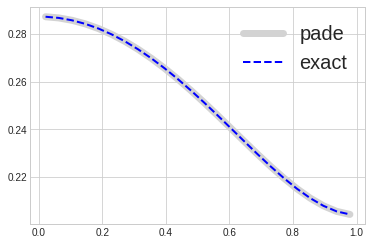

In [453]:
#@title solve dicretized version of $\frac{d^2y}{dx^2}+y = x^3$ by matrix inversion 
bgn = 0; fin = 1 
size = 24; h = (fin-bgn)/size
x = np.linspace(bgn+h/2,fin-h/2,size)
A = np.zeros([size,size])
B = np.zeros([size,size])
C = np.zeros([size])

# update A B C for the first/last row
cl = 23*np.array([1,-11/23,0])
cr = 23*np.array([-36/23,48/23,-12/23])
A[0,0:3] = cl 
B[0,0:3] = cr 
C[0] = np.dot(cl,x[0:3]**3)
cl = 23*np.array([0,-11/23,1])
cr = 23*np.array([-12/23,48/23,-36/23])
A[size-1,size-3:size] = cl
B[size-1,size-3:size] = cr
C[size-1] = np.dot(cl,x[size-3:size]**3)
cl = np.array([1,10,1])
cr = np.array([12,-24,12])
for i in range(1,size-1):
  A[i,i-1:i+2] = cl
  B[i,i-1:i+2] = cr
  C[i] = np.dot(cl,x[i-1:i+2]**3)
solution = np.linalg.inv(A+B/h**2)@(C)
plt.plot(x,solution,linewidth=7,color='lightgray')
exact =  (6*np.cos(1)-3)/np.sin(1)*np.cos(x)\
          + 6*np.sin(x) + x**3 -6*x
plt.plot(x,exact,'--',linewidth=2,color='blue')
plt.legend(["pade","exact"], prop={"size":20})

from termcolor import colored
print('first 5 row and column of A:\n',colored(A[:5,:5],'green'))
print('first 5 row and colomn of B:\n',colored(B[:5,:5],'blue'),colored('/h**2','blue'))

I guess you don't need to use matrix inversion if you use thomas for the inner most diagonals and move the other two nonzero elements to the right hand side and guess some values for the y and in a iterative process like secant update the y until they converge to some certain value (solution).